# Fancy Indexing

__Fancy indexing uses arrays of indices in place of single scalars.__ This allows us to very quickly access and modify complicated subsets of an array's values.

In [1]:
import numpy as np
rand = np.random.RandomState(42)

x = rand.randint(100, size=10)
x

array([51, 92, 14, 71, 60, 20, 82, 86, 74, 74])

Suppose we want to access three different elements. We could do it like this:

In [2]:
[x[3], x[7], x[2]]

[71, 86, 14]

We can pass a single list or array of indices to obtain the same result:

In [3]:
ind = [3, 7, 4]
x[ind]

array([71, 86, 60])

When using fancy indexing, __the shape of the result reflects the shape of the index arrays__ - not the shape of the array being indexed.

In [4]:
ind = np.array([[3, 7],
                [4, 5]])
x[ind]

array([[71, 86],
       [60, 20]])

Fancy indexing also works in multiple dimensions.

In [5]:
X = np.arange(12).reshape((3, 4))
X

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

Like with standard indexing, the first index refers to the row, and the second to the column:

In [6]:
rows = np.array([0, 1, 2])
cols = np.array([2, 1, 3])
X[rows, cols]

array([ 2,  5, 11])

Notice that the first value in the result is ``X[0, 2]``, the second is ``X[1, 1]``, and the third is ``X[2, 3]``.
So if we combine a column vector and a row vector within the indices, we get a two-dimensional result:

In [8]:
X[rows[:, np.newaxis], cols]

array([[ 2,  1,  3],
       [ 6,  5,  7],
       [10,  9, 11]])

Here, each row value is matched with each column vector, exactly as we saw in broadcasting of arithmetic operations.
For example:

In [9]:
rows[:, np.newaxis] * cols

array([[0, 0, 0],
       [2, 1, 3],
       [4, 2, 6]])

### Combined Indexing

In [11]:
X

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [13]:
X[2, [2, 0, 1]]                       # fancy indexing with simple indices

array([10,  8,  9])

In [14]:
X[1:, [2, 0, 1]]                      # fancy indexing with slices

array([[ 6,  4,  5],
       [10,  8,  9]])

In [16]:
mask = np.array([1, 0, 1, 0], dtype=bool)     # fancy indexing with masks
X[rows[:, np.newaxis], mask]

array([[ 0,  2],
       [ 4,  6],
       [ 8, 10]])

### Example: Selecting Random Points

One common use of fancy indexing is selecting subsets of rows from a matrix. For example, we might have an $N$ by $D$ matrix representing $N$ points in $D$ dimensions, such as the following points drawn from a two-dimensional normal distribution:

In [17]:
mean = [0, 0]
cov = [[1, 2],
       [2, 5]]
X = rand.multivariate_normal(mean, cov, 100)
X.shape

(100, 2)

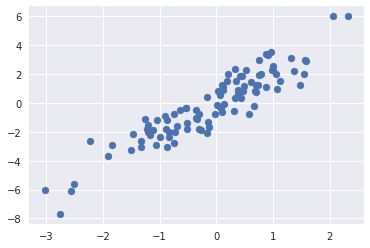

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # for plot styling

plt.scatter(X[:, 0], X[:, 1]);

Use fancy indexing to select 20 random points. We'll do this by first choosing 20 random indices with no repeats, and use these indices to select a portion of the original array.

This is a common technique for dataset partitions (often used for train/test splits in model validations).

In [19]:
indices = np.random.choice(X.shape[0], 20, replace=False)
indices

array([51, 35, 62, 38, 90, 85, 40, 71, 39, 65, 94, 83, 77, 67, 49, 80, 81,
        7, 48, 37])

In [20]:
selection = X[indices]  # fancy indexing here
selection.shape

(20, 2)

Now to see which points were selected, let's over-plot large circles at the locations of the selected points:

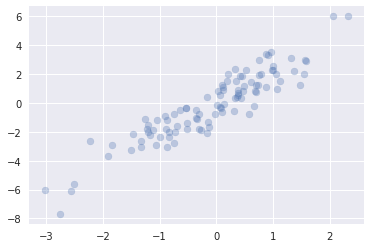

In [21]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
plt.scatter(selection[:, 0], selection[:, 1], facecolor='none', s=200);

### Modifying Values with Fancy Indexing

Fancy indexing can also modify parts of an array. Imagine we have an array of indices and we'd like to set the corresponding items in an array to some value.

In [22]:
x = np.arange(10)
i = np.array([2, 1, 8, 4])
x[i] = 99
x

array([ 0, 99, 99,  3, 99,  5,  6,  7, 99,  9])

In [23]:
x[i] -= 10                             # using an assignment-type operator
x

array([ 0, 89, 89,  3, 89,  5,  6,  7, 89,  9])

Consider the following. What happened to the 4?

In [24]:
x = np.zeros(10)
x[[0, 0]] = [4, 6]
print(x)

[ 6.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


This operation first assigned ``x[0] = 4``, then ``x[0] = 6``. Consider:

In [25]:
i = [2, 3, 3, 4, 4, 4]
x[i] += 1
x

array([ 6.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.])

You might expect that ``x[3]`` would contain the value 2, and ``x[4]`` would contain the value 3, as this is how many times each index is repeated. Why not? Because ``x[i] += 1`` is meant as a shorthand of ``x[i] = x[i] + 1``. ``x[i] + 1`` is evaluated, and then the result is assigned to the indices in x.

__It's not the augmentation that happens multiple times - but the assignment, which leads to the rather nonintuitive results.__

If you want the other behavior where the operation is repeated? __For this, you can use the ``at()`` method of ufuncs.__

In [27]:
x = np.zeros(10)
np.add.at(x, i, 1)
x

array([ 0.,  0.,  1.,  2.,  3.,  0.,  0.,  0.,  0.,  0.])

``at()`` does an in-place application of the given operator at the specified indices (here, ``i``) with the specified value (here, 1). ``reduceat()`` is a similar method.

### Example: Binning Data

Imagine we have 1,000 values and would like to find where they fall within an array of bins.
We could compute it using ``ufunc.at`` like this:

In [29]:
np.random.seed(42)
x = np.random.randn(100)

bins = np.linspace(-5, 5, 20)                   # compute a histogram by hand
counts = np.zeros_like(bins)

i = np.searchsorted(bins, x)                    # find the appropriate bin for each x

np.add.at(counts, i, 1)                         # add 1 to each of these bins

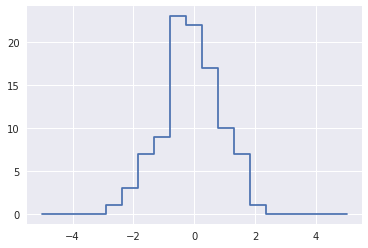

In [30]:
plt.plot(bins, counts, linestyle='steps');

Matplotlib provides the ``plt.hist()`` routine, which does the same in a single line:

```python
plt.hist(x, bins, histtype='step');
```

This function will create a nearly identical plot to the one seen here.
To compute the binning, ``matplotlib`` uses the ``np.histogram`` function, which does a very similar computation to what we did before. Let's compare the two here:

In [31]:
print("NumPy routine:")
%timeit counts, edges = np.histogram(x, bins)

print("Custom routine:")
%timeit np.add.at(counts, np.searchsorted(bins, x), 1)

NumPy routine:
58.1 µs ± 900 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Custom routine:
13.5 µs ± 522 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


NumPy's algorithm is more flexible, and __is designed for better performance when the number of data points becomes large:__

In [32]:
x = np.random.randn(1000000)
print("NumPy routine:")
%timeit counts, edges = np.histogram(x, bins)

print("Custom routine:")
%timeit np.add.at(counts, np.searchsorted(bins, x), 1)

NumPy routine:
63.8 ms ± 826 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Custom routine:
95.1 ms ± 935 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
